## Understanding Gender and Racial Disparities in Image Recognition Models

### Responsible Data Science Course Project: Nutritional Labels for Automated Decision Systems (ADS)

Rohan Mahadev - rm5310, Anindya Chakravarti - ac8184

The entire repository can be found here - https://github.com/anindya/rds_project

We use Azat Davletshin's 4th place solution to the Kaggle Inclusive Images Challenge and analyze it's performance on the gender classification task on the MR2 dataset. To put these results in context, we also use a baseline ResNet model trained on the CelebA dataset  

The ADS uses PyTorch to perform image classification. Along with that we use pandas to perform fairness analysis and LIME to interpret the results of the ADS and the baseline model.

The baseline model is pretrained on ImageNet and then finetuned on the CelebA dataset. We want to understand whether the distributional skew in ImageNet and Open Images affects gender classification.

A detailed analysis of these results can be found in the paper that complements this Notebook.

In [1]:
import os
import yaml
import pickle
import argparse

import numpy as np
import torch
torch.backends.cudnn.benchmark=True
from torch import nn
from torch.nn import functional as F
from torch.utils.data import DataLoader
from PIL import Image

from datasets import LabeledImages
from models.se_resnet import se_resnet101

import torchvision.transforms as T
import torchvision
import pandas as pd

from lime import lime_image

from skimage.segmentation import mark_boundaries

# import cv2
import matplotlib.pyplot as plt
%matplotlib inline
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

In [2]:
CONFIG_PATH = './config.yaml'
MR2_FACES_DATA_PATH = "./data/mr2_faces/"
MR2_DATASET_CSV_PATH = "./data/dataset.csv"
PRED_KEY = "Predicted Gender"
BASE_PRED_KEY = "Baseline Prediction"
FLAGGED_KEY = "Flagged"

In [3]:
race = ["Black", "Asian", "European"]

# ADS being evaluated

In [4]:
class Classifier(nn.Module):
    def __init__(self, n_classes):
        super(Classifier, self).__init__()
        self.n_classes = n_classes
        self.features = se_resnet101()
        self.classifier = nn.Linear(2048, n_classes)

    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x

class ModelWithLoss(nn.Module):
    def __init__(self, classifier):
        super(ModelWithLoss, self).__init__()
        self.classifier = classifier
        self.criterion = nn.CrossEntropyLoss(size_average=False)

    def forward(self, x, labels):
        assert len(x) == len(labels)

        predictions = self.classifier(x)

        all_classes = np.arange(self.classifier.n_classes, dtype=np.int64)
        zero_label = torch.tensor([0]).to(x.device)

        loss = 0
        denominator = 0
        for prediction, positives in zip(predictions, labels):
            negatives = np.setdiff1d(all_classes, positives, assume_unique=True)
            negatives_tensor = torch.tensor(negatives).to(x.device)
            positives_tensor = torch.tensor(positives).to(x.device).unsqueeze(dim=1)

            for positive in positives_tensor:
                indices = torch.cat((positive, negatives_tensor))
                loss = loss + self.criterion(prediction[indices].unsqueeze(dim=0), zero_label)
                denominator += 1

        loss /= denominator

        return loss

    def predict(self, x):
        input_shape = x.shape
        if len(input_shape) == 5:
            x = x.view(-1, input_shape[2], input_shape[3], input_shape[4])
            predictions = self.classifier(x)
            predictions = predictions.view(input_shape[0], input_shape[1], -1).mean(dim=1)
        else:
            predictions = self.classifier(x)

        return predictions

In [11]:
with open(CONFIG_PATH, 'r') as f:
    config = yaml.load(f)

In [12]:
with open(config['DATASET']['NAME_TO_LABEL_PATH'], 'rb') as f:
    name_to_label = pickle.load(f)
label_to_name = {label: name for name, label in name_to_label.items()}
n_classes = len(name_to_label)

In [13]:
classifier = Classifier(n_classes)
model = ModelWithLoss(classifier).to(device).eval()

/home/rm5310/pyenv/py3.6.3/lib/python3.6/site-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


Here we load the model trained by the ADS. It is available to download here: https://drive.google.com/file/d/1rg5m7xKXGdc3jnaI-QKLKtpwUPAmieeP/view

In [14]:
snapshot_path = os.path.join(config['TUNING']['ARTIFACTS_ROOT'], 'snapshots',
                                 'snapshot_epoch_{}.pth.tar'.format(config['TUNING']['N_EPOCH']))
state = torch.load(snapshot_path, map_location=lambda storage, loc: storage)
model.load_state_dict(state['model'])

<All keys matched successfully>

Normalization metrics are calculated on the Open Images dataset

In [15]:
normalize = T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
to_tensor = T.Compose([T.ToTensor(), normalize])

In [16]:
description = pd.read_csv('./class-descriptions2.csv')
label_lookup = {label: descr for label, descr in zip(description.label_code.values, description.description.values)}

These are the functions that generate the prediction from the ADS

In [17]:
def get_image(path):
    with open(os.path.abspath(path), 'rb') as f:
        with Image.open(f) as img:
            return img.convert('RGB')

In [18]:
def run_pred(path):    
    img = get_image(path)
    transform = T.Compose([T.Resize(256),T.CenterCrop(224),
                           to_tensor])
    img1 = transform(img)
    img1 = img1.unsqueeze(0)

    with torch.no_grad():
        pred_scores = model.predict(img1.to(device))
        return pred_scores

In [19]:
def detailed_preds(path):
    probs = run_pred(path)
    scores, labels = probs.sort(dim=1, descending=True)
    names = [label_lookup[label_to_name[label.item()]] for label in labels[0]]
    return names

### Load the MR2 dataset for evaluation

In [21]:
mr2_data = pd.read_csv(MR2_DATASET_CSV_PATH)
y_pred = []

# 0 = Female, 1 = Male
labels_list = {
    "Girl" : 0, 
    "Woman" : 0,
    "Man" : 1,
    "Boy" : 1
}

In [22]:
for name in mr2_data.name:
    prediction_list = detailed_preds(MR2_FACES_DATA_PATH + name +".tif")
    for pred_name in prediction_list:
        if pred_name in labels_list.keys():
            y_pred.append(labels_list[pred_name])
            break
mr2_data[PRED_KEY] = y_pred

We flag the incorrect predictions which are then used for the fairness analysis 

In [23]:
def flagPredictions():
    mr2_data[FLAGGED_KEY] = [False]*mr2_data.shape[0]
    mr2_data.loc[(mr2_data[PRED_KEY] == 1) & (mr2_data['sex'] == "Female"), FLAGGED_KEY] = True
    mr2_data.loc[(mr2_data[PRED_KEY] == 0) & (mr2_data['sex'] == "Male"), FLAGGED_KEY] = True

In [24]:
flagPredictions()

Here are some flagged predictions for females:

In [25]:
mr2_data[(mr2_data[FLAGGED_KEY] == True) & (mr2_data["sex"] == "Female")]

,name,race,sex,Predicted Gender,Flagged
4,af12,Asian,Female,1,True
6,wf02,European,Female,1,True
7,af10,Asian,Female,1,True
8,af04,Asian,Female,1,True
11,af05,Asian,Female,1,True
22,wf10,European,Female,1,True
29,af03,Asian,Female,1,True
30,wf07,European,Female,1,True
32,bf08,Black,Female,1,True
36,bf18,Black,Female,1,True


# Fairness metrics

In [26]:
from sklearn.metrics import confusion_matrix

### Confusion Matrix

In [27]:
def getConfusionMatrix(data_df, pred_key):
    confusionMatrix = confusion_matrix(data_df["sex"].tolist(), data_df[pred_key].tolist())
    print(confusionMatrix)
    return confusionMatrix

### FPR Analysis

In [28]:
def fpr_analysis(confusionMatrix):
    ff, fm, mf, mm = confusionMatrix.ravel()
    FPR_FEMALE = fm/(fm+ff)
    FPR_MALE = mf/(mm+mf)
    print("FPR Female : ", FPR_FEMALE)
    print("FPR Male : ", FPR_MALE)
    print("FPR Difference (Female - Male) : ", FPR_FEMALE - FPR_MALE)

### Disparate Impact

In [29]:
def disparate_impact(confusionMatrix):
    ff, fm, mf, mm = confusionMatrix.ravel()
    di = ((ff)/(fm+ff))/(mm/(mm + mf))
    print ("Disparate Impact : ", di)
    return di

# Nutritional Labels


In [30]:
def accuracy_metrics(data_df, pred_key):
    df_copy = data_df[["sex", pred_key]]
    df_copy.loc[df_copy["sex"] == "Female", "sex"] = 0
    df_copy.loc[df_copy["sex"] == "Male", "sex"] = 1
    confusionMatrix = getConfusionMatrix(df_copy, pred_key)
    fpr_analysis(confusionMatrix)
    disparate_impact(confusionMatrix)

In [31]:
def getMetricsCompleteAndByRace(data_df, pred_key):
    print("-"*32)
    accuracy_metrics(data_df, pred_key)
    print("-"*32)
    print("\n Comparision For Individual Race")
    for r in race:
        print("-"*12 + r + "-"*12)
        accuracy_metrics(data_df.loc[data_df["race"] == r], pred_key)
        print("-"*32)
        print("\n")

In [32]:
def getDataMetricsRace(data_df, protected_race, privelege_race, pred_key):
    correct_classifications_protected = data_df.loc[(data_df["race"] == protected_race) & (data_df[pred_key] == 0)].shape[0]
    incorrect_classifications_protected = data_df.loc[(data_df["race"] == protected_race) & (data_df[pred_key] == 1)].shape[0]
    correct_classifications_privileged = data_df.loc[(data_df["race"] == privelege_race) & (data_df[pred_key] == 0)].shape[0]
    incorrect_classifications_privileged = data_df.loc[(data_df["race"] == privelege_race) & (data_df[pred_key] == 1)].shape[0]

    FPR_protected = incorrect_classifications_protected/(correct_classifications_protected + incorrect_classifications_protected)
    FPR_privileged = incorrect_classifications_privileged/(correct_classifications_privileged + incorrect_classifications_privileged)
    print("FPR protected : ", FPR_protected)
    print("FPR privileged : ", FPR_privileged)
    print("FPR Difference (Protected - Privileged) : ", FPR_protected - FPR_privileged)
    if (FPR_privileged != 1):
        disparate_impact = (1-FPR_protected)/(1-FPR_privileged)
    else:
        disparate_impact = np.nan
    print("Disparate Impact : ", disparate_impact)

In [33]:
def getAllRaceMetrics(data_df, pred_key):
    for r in race:
        if r == "European":
            continue
        print("-"*12 + r + "-"*12)
        getDataMetricsRace(data_df, r, "European", pred_key)
        print("-"*32)
        print("\n")
    

# Baseline Model

In [2]:
#Load the pretrained model from Torchvision
model_ft = torchvision.models.resnet18(pretrained=True)
num_ftrs = model_ft.fc.in_features
# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).
model_ft.fc = nn.Linear(num_ftrs, 2)

#trained separately using ResNet18 architecture and CelebA dataset
#Model available here https://tinyurl.com/y9znjo4v
model_ft.load_state_dict(torch.load("./models/resnet_ft.pth", map_location=torch.device(device)))
model_ft.eval()
model_ft = model_ft.to(device)


In [35]:
def run_baseline_pred(path):    
    img = get_image(path)
    transform = T.Compose([T.CenterCrop((178, 178)),
                           T.Resize((128, 128)),
                           T.ToTensor()])
    img1 = transform(img)
    img1 = img1.unsqueeze(0)

    with torch.no_grad():
        x = model_ft(img1.to(device))
        pred_scores = F.softmax(x, dim=1)
        return pred_scores

In [37]:
y_pred = []
for name in mr2_data.name:
    res = run_baseline_pred(MR2_FACES_DATA_PATH + name + ".tif")
    if res[0][0] > res[0][1]:
        y_pred.append(0)
    else:
        y_pred.append(1)
mr2_data[BASE_PRED_KEY] = y_pred

# Metrics : Baseline Model and Kaggle ADS

In [39]:
print("ADS Nutrition Labels")
getMetricsCompleteAndByRace(mr2_data, PRED_KEY)

ADS Nutrition Labels
--------------------------------


/share/apps/python3/3.6.3/intel/lib/python3.6/site-packages/pandas-0.22.0-py3.6-linux-x86_64.egg/pandas/core/indexing.py:537: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


[[18 23]
 [ 0 33]]
FPR Female :  0.5609756097560976
FPR Male :  0.0
FPR Difference (Female - Male) :  0.5609756097560976
Disparate Impact :  0.43902439024390244
--------------------------------

 Comparision For Individual Race
------------Black------------
[[ 4 14]
 [ 0 14]]
FPR Female :  0.7777777777777778
FPR Male :  0.0
FPR Difference (Female - Male) :  0.7777777777777778
Disparate Impact :  0.2222222222222222
--------------------------------


------------Asian------------
[[6 6]
 [0 8]]
FPR Female :  0.5
FPR Male :  0.0
FPR Difference (Female - Male) :  0.5
Disparate Impact :  0.5
--------------------------------


------------European------------
[[ 8  3]
 [ 0 11]]
FPR Female :  0.2727272727272727
FPR Male :  0.0
FPR Difference (Female - Male) :  0.2727272727272727
Disparate Impact :  0.7272727272727273
--------------------------------




In [40]:
print("Baseline Nutrition Labels")
getMetricsCompleteAndByRace(mr2_data, BASE_PRED_KEY)

Baseline Nutrition Labels
--------------------------------
[[ 4 37]
 [ 1 32]]
FPR Female :  0.9024390243902439
FPR Male :  0.030303030303030304
FPR Difference (Female - Male) :  0.8721359940872137
Disparate Impact :  0.10060975609756098
--------------------------------

 Comparision For Individual Race
------------Black------------


/share/apps/python3/3.6.3/intel/lib/python3.6/site-packages/pandas-0.22.0-py3.6-linux-x86_64.egg/pandas/core/indexing.py:537: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


[[ 2 16]
 [ 1 13]]
FPR Female :  0.8888888888888888
FPR Male :  0.07142857142857142
FPR Difference (Female - Male) :  0.8174603174603174
Disparate Impact :  0.11965811965811965
--------------------------------


------------Asian------------
[[ 2 10]
 [ 0  8]]
FPR Female :  0.8333333333333334
FPR Male :  0.0
FPR Difference (Female - Male) :  0.8333333333333334
Disparate Impact :  0.16666666666666666
--------------------------------


------------European------------
[[ 0 11]
 [ 0 11]]
FPR Female :  1.0
FPR Male :  0.0
FPR Difference (Female - Male) :  1.0
Disparate Impact :  0.0
--------------------------------




In [41]:
female_only_data = mr2_data.loc[mr2_data["sex"] == "Female"]

In [42]:
getAllRaceMetrics(female_only_data, PRED_KEY)

------------Black------------
FPR protected :  0.7777777777777778
FPR privileged :  0.2727272727272727
FPR Difference (Protected - Privileged) :  0.5050505050505051
Disparate Impact :  0.3055555555555555
--------------------------------


------------Asian------------
FPR protected :  0.5
FPR privileged :  0.2727272727272727
FPR Difference (Protected - Privileged) :  0.2272727272727273
Disparate Impact :  0.6875
--------------------------------




In [43]:
getAllRaceMetrics(mr2_data, BASE_PRED_KEY)

------------Black------------
FPR protected :  0.90625
FPR privileged :  1.0
FPR Difference (Protected - Privileged) :  -0.09375
Disparate Impact :  nan
--------------------------------


------------Asian------------
FPR protected :  0.9
FPR privileged :  1.0
FPR Difference (Protected - Privileged) :  -0.09999999999999998
Disparate Impact :  nan
--------------------------------




# LIME

In [44]:
def get_pil_transform(): 
    transf = T.Compose([
        T.Resize((256, 256)),
        T.CenterCrop(224)
    ])    

    return transf

def get_preprocess_transform():
    normalize = T.Normalize(mean=[0.485, 0.456, 0.406],
                                    std=[0.229, 0.224, 0.225])     
    transf = T.Compose([
        T.ToTensor(),
        normalize
    ])    

    return transf    

pill_transf = get_pil_transform()
preprocess_transform = get_preprocess_transform()

In [45]:
def batch_pred_ads(images):
    batch = torch.stack(tuple(preprocess_transform(i) for i in images), dim=0)
    with torch.no_grad():
        pred_scores = model.predict(batch.to(device))
        return pred_scores.detach().cpu().numpy()

In [46]:
def batch_pred_baseline(images):
    batch = torch.stack(tuple(preprocess_transform(i) for i in images), dim=0)
    with torch.no_grad():
        x = model_ft(batch.to(device))
        pred_scores = F.softmax(x, dim=1)
        return pred_scores.detach().cpu().numpy()

In [61]:
label_name_to_idx = {
    "ADS": {
        "Man" : 54,
        "Woman" : 41,
        "Boy" : 9,
        "Girl" : 58
    },
    "Baseline": {
        "Woman": 0,
        "Man": 1
    }
}

prediction_function = {
    "ADS" : batch_pred_ads,
    "Baseline": batch_pred_baseline
}

def limeDescription(label_name, path, model_type):
    img = get_image(path)
    explainer = lime_image.LimeImageExplainer()
    explanation = explainer.explain_instance(np.array(pill_transf(img)), 
                                             prediction_function[model_type], # classification function
                                             top_labels=18155, # number of classes 
                                             hide_color=0, 
                                             num_samples=1000) # number of images that will be sent to classification function
    temp, mask = explanation.get_image_and_mask(label_name_to_idx[model_type][label_name], positive_only=False, num_features=10, hide_rest=False)
    img_boundry2 = mark_boundaries(temp/255.0, mask)
    plt.imshow(img_boundry2)
    plt.show()

In [62]:
def getAllLimeDescription(image_path, model_type):
    for label_name in ["Man", "Woman"]:
        print (label_name)
        limeDescription(label_name, image_path, model_type)

Man


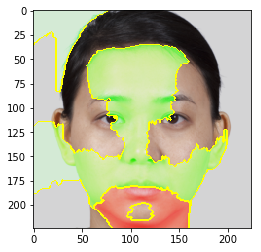

Woman


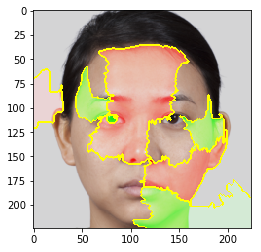

CPU times: user 6min 10s, sys: 6min 28s, total: 12min 39s
Wall time: 3min 12s


In [63]:
%%time
getAllLimeDescription(MR2_FACES_DATA_PATH+"af10.tif", model_type="ADS")

Man


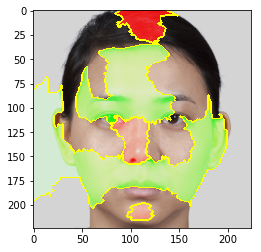

Woman


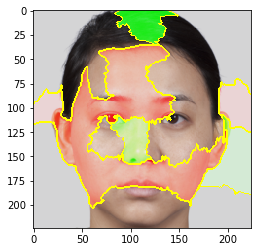

In [64]:
getAllLimeDescription(MR2_FACES_DATA_PATH+"af10.tif", model_type="Baseline")

Man


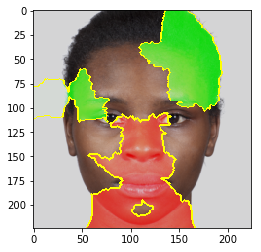

Woman


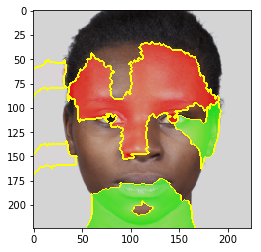

In [65]:
getAllLimeDescription(MR2_FACES_DATA_PATH+"bf15.tif", model_type="Baseline")

Man


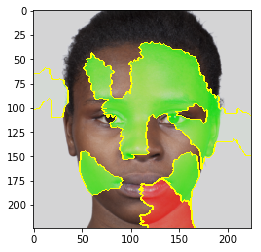

Woman


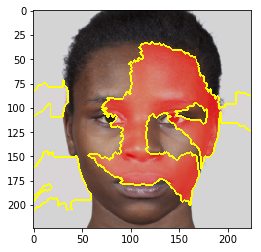

In [66]:
getAllLimeDescription(MR2_FACES_DATA_PATH+"bf15.tif", model_type="ADS")

Man


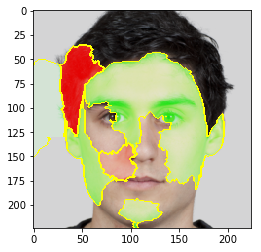

Woman


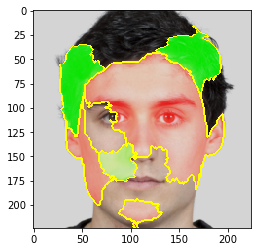

In [67]:
getAllLimeDescription(MR2_FACES_DATA_PATH+"wm06.tif", model_type="ADS")

Man


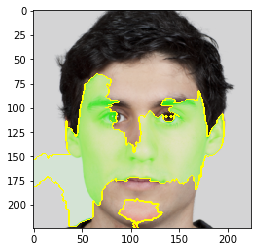

Woman


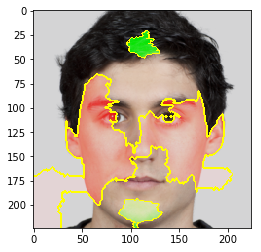

In [68]:
getAllLimeDescription(MR2_FACES_DATA_PATH+"wm06.tif", model_type="Baseline")

Man


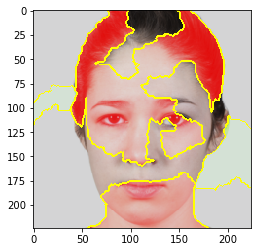

Woman


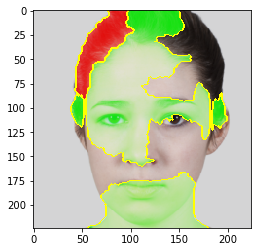

In [69]:
getAllLimeDescription(MR2_FACES_DATA_PATH+"wf04.tif", model_type="ADS")

Man


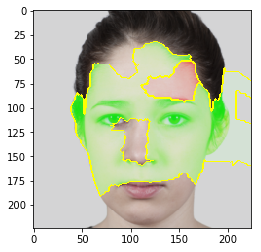

Woman


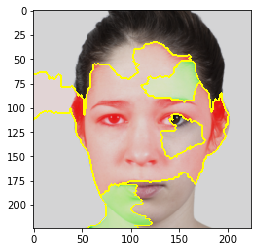

In [70]:
getAllLimeDescription(MR2_FACES_DATA_PATH+"wf04.tif", model_type="Baseline")